# Imports

In [1]:
# Tobi

from sklearn.ensemble import RandomForestClassifier
import sklearn.metrics as metrics
from xgboost import XGBClassifier
from sklearn.feature_selection import VarianceThreshold, SelectFromModel

In [2]:
# Simon

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.tree import plot_tree
from sklearn.tree import DecisionTreeClassifier

# Data Analysis Tobi

In [3]:
mushrooms_train = pd.read_csv('data/train.csv')
mushrooms_test = pd.read_csv('data/test.csv')

## Value Counts
* Balanced classes
* All data categorical
* Some categories have only few members

In [4]:
for column in mushrooms_train.columns:
    print(column, '\n', mushrooms_train[column].value_counts().sort_values(ascending=False), '\n')

cap.shape 
 x    2935
f    2534
k     652
b     349
s      28
c       1
Name: cap.shape, dtype: int64 

cap.color 
 n    1823
g    1487
e    1197
y     848
w     823
b     143
p     117
c      34
u      14
r      13
Name: cap.color, dtype: int64 

bruises 
 False    3764
True     2735
Name: bruises, dtype: int64 

stalk.color.above.ring 
 w    3537
p    1536
g     452
n     358
b     346
o     156
e      78
c      29
y       7
Name: stalk.color.above.ring, dtype: int64 

stalk.color.below.ring 
 w    3481
p    1494
g     467
n     421
b     352
o     156
e      80
c      29
y      19
Name: stalk.color.below.ring, dtype: int64 

population 
 v    3219
y    1392
s     993
n     320
a     302
c     273
Name: population, dtype: int64 

Id 
 6573    1
1895    1
5789    1
6187    1
2508    1
       ..
6206    1
4658    1
5000    1
6381    1
373     1
Name: Id, Length: 6499, dtype: int64 

poisonous 
 0    3342
1    3157
Name: poisonous, dtype: int64 



## Missing Values
* No missing values

In [5]:
for column in mushrooms_test.columns:
    print(column, '\n', mushrooms_test[column].isna().sum(), '\n')

Id 
 0 

cap.shape 
 0 

cap.color 
 0 

stalk.color.above.ring 
 0 

stalk.color.below.ring 
 0 

bruises 
 0 

population 
 0 



# Preprocessor pipe

In [4]:
columns = mushrooms_train.columns[:-2]

cat_pipe = Pipeline(steps= [
    ('transformer', OneHotEncoder())
    ])

preprocessor = ColumnTransformer(
    transformers=[
        ('cat_pipe', cat_pipe, columns),
    ], verbose= False
)

# Conduct Preprocessing

In [5]:
# Split in features and target
X = mushrooms_train.drop(['poisonous'], axis=1)
y = mushrooms_train['poisonous']

# copy for manual false Positives Tuning
X_2 = X.copy()
y_2 = y.copy()

In [6]:
# Preprocess train data
X.drop('Id', axis=1, inplace = True)

# Split in train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1337)

In [7]:
# Preprocess final test data
X_test_final = mushrooms_test.drop(['Id'], axis=1)

# Functions

## Plot AUROC

In [8]:
def plotAUROC(model, X_test, y_test):
    probs = model.predict_proba(X_test)
    preds = probs[:,1]
    fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
    roc_auc = metrics.auc(fpr, tpr)

    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

## Get Confusion Matrix

In [9]:
def get_confusion_matrix(y, y_pred):
    confusion_matrix = pd.DataFrame(metrics.confusion_matrix(y, y_pred),
                                    columns=['Predicted Not Poisonous', 'Predicted Poisonous'],
                                    index=['True Not Poisonous', 'True Poisonous']
                                    )
    return confusion_matrix

## Calculate False Negative Rate

In [10]:
def calculate_false_negative_rate(y, y_pred):

    confusion_matrix = get_confusion_matrix(y, y_pred)
    false_negative_rate = confusion_matrix.loc['True_Poisonous', 'Predicted_Not_Poisonous'] / confusion_matrix.loc['True_Poisonous', :].sum()

    return false_negative_rate

## Gridsearch

In [11]:
def gridsearch(parameter_name, parameter_values, pipeline, X_train, y_train, X_test, y_test):
    
    best_value = None

    for value in parameter_values:
        pipeline.set_params(**{f'classifier__{parameter_name}': value})
        pipeline.fit(X_train, y_train)

        y_pred_test = pipeline.predict(X_test)
        false_negative_rate = calculate_false_negative_rate(y_test, y_pred_test)

        if best_value is None or false_negative_rate < best_value[1]:
            best_value = (value, false_negative_rate) 
    
    return best_value

## Get Ids of False Positives

In [12]:
def returnFalsePositivesIndex (test, pred_test):
    #get index of false positives
    falsePositivesIndex = (
        pd.DataFrame(test)
        .assign(prediction=pred_test)
        .query('poisonous == 0 & prediction == 1')
        .index
    )

    return list(falsePositivesIndex)

# Random Forest

In [13]:
random_forest_pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(  random_state=1337,
                                            class_weight = {0: 1, 1: 10}))
    ])

In [14]:
random_forest_pipe.fit(X_train, y_train)

y_pred_train = random_forest_pipe.predict(X_train)
y_pred_test = random_forest_pipe.predict(X_test)

print('Accuracy on train-set: ', accuracy_score(y_true = y_train, y_pred = y_pred_train))
print('Accuracy on test-set: ', accuracy_score(y_true = y_test, y_pred = y_pred_test))

Accuracy on train-set:  0.9417195614541258
Accuracy on test-set:  0.95


### Change false Positives to true

In [15]:
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_2, y_2, test_size=0.2, random_state=1337)

In [16]:
random_forest_pipe.fit(X_train_2, y_train_2)

y_pred_train_2 = random_forest_pipe.predict(X_train_2)
y_pred_test_2 = random_forest_pipe.predict(X_test_2)

print('Accuracy on train-set: ', accuracy_score(y_true = y_train_2, y_pred = y_pred_train_2))
print('Accuracy on test-set: ', accuracy_score(y_true = y_test_2, y_pred = y_pred_test_2))

Accuracy on train-set:  0.9451817657241778
Accuracy on test-set:  0.9392307692307692


In [18]:
def modify_X(X, y, n):
    
    y = pd.DataFrame(y)
    
    for i in range(n):   
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
        
        random_forest_pipe.fit(X_train, y_train)

        y_pred = random_forest_pipe.predict(X_test)

        indices = returnFalsePositivesIndex (y_test, y_pred)

        y.loc[pd.DataFrame(y).index.isin(indices), 'poisonous'] = 1

    return y

In [25]:
y_final = modify_X(X_2, y_2, 5)

c:\Users\tobia\miniconda3\envs\home\lib\site-packages\sklearn\pipeline.py:382: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
c:\Users\tobia\miniconda3\envs\home\lib\site-packages\sklearn\pipeline.py:382: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
c:\Users\tobia\miniconda3\envs\home\lib\site-packages\sklearn\pipeline.py:382: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
c:\Users\tobia\miniconda3\envs\home\lib\site-packages\sklearn\pipeline.py:382: DataConversionWarning: A column-vector y w

In [26]:
comparison = pd.concat([y, y_final], axis = 1)

comparison.columns.values[0] = 'original'
comparison.columns.values[1] = 'modified'

(
    comparison
        .loc[comparison['original'] != comparison['modified'], :]
)

,original,modified
5,0,1
11,0,1
16,0,1
113,0,1
118,0,1
...,...,...
6359,0,1
6361,0,1
6389,0,1
6411,0,1


# Plot Models

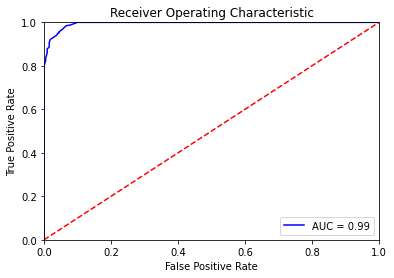

In [27]:
plotAUROC(random_forest_pipe, X_test, y_test)

In [28]:
get_confusion_matrix(y_test, y_pred_test)

,Predicted Not Poisonous,Predicted Poisonous
True Not Poisonous,586,65
True Poisonous,0,649


# Final Output

In [34]:
random_forest_pipe.fit(X, y_final)
y_pred_final = random_forest_pipe.predict(X_test_final)

c:\Users\tobia\miniconda3\envs\home\lib\site-packages\sklearn\pipeline.py:382: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


In [35]:
(
    mushrooms_test
    .assign(poisonous=y_pred_final)
    [['Id', 'poisonous']]
    .to_csv('submission.csv', index=False)
)